# Simple and Multiple Linear Regression

## Libraries and settings

In [67]:
# Libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/applied_research_methods/Week_07


## Import the apartment data

In [68]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'mean_taxable_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("./Data/apartments_data_enriched_cleaned.csv", 
                      sep=";", 
                      encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

print(df.shape)
df.head(5)

(722, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income,dist_supermarket
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49,0,1441,29.41,47.252171,8.845797,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,645.652248
1,1693998233-172,"Widacherstrasse 5, 8630 Rüti ZH, ZH",3.0,111,0,2600,23.42,47.252087,8.854919,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,265.102153
2,1693998256-331,"Widenweg 14, 8630 Rüti ZH, ZH",3.0,58,0,1490,25.69,47.253670,8.853993,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,94.401821
3,1693998265-381,"Rain 1, 8630 Rüti ZH, ZH",4.0,118,0,3240,27.46,47.259834,8.851705,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,106.660970
4,1693998276-419,"Bachtelstrasse 24b, 8630 Rüti ZH, ZH",3.0,66,0,1450,21.97,47.266113,8.866872,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,974.844209


## Simple linear regression (only one explanatory variable in the model)
For details see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [31]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df['area'], 
                                                    df['price'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
503    120
6       65
400     90
644     63
484     91
Name: area, dtype: int64 

y_train:
503    1900
6      1850
400    2090
644    2102
484    1800
Name: price, dtype: int64


### Fit the simple linear regression model

In [32]:
# Add constant to the model
X_train_const = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_const).fit()

# Get the slope and intercept
intercept, slope = model.params

# Get the confidence intervals
conf = model.conf_int()

# Get R-squared and p-value
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the slope

# Print results of the regression model
print('Linear regression result:')
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.2f}")
print(f"Confidence Interval for Slope: {conf.iloc[1].values}")
print(f"Confidence Interval for Intercept: {conf.iloc[0].values}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")


Linear regression result:
Slope: 13.5481
Intercept: 1272.94
Confidence Interval for Slope: [12.09315846 15.00306028]
Confidence Interval for Intercept: [1135.4218772  1410.46346142]
R-squared: 0.3678
P-value: 0.0000


Own notes: R-squared = 36% of the variation of our target value is explained by the data.

### Plot regression line

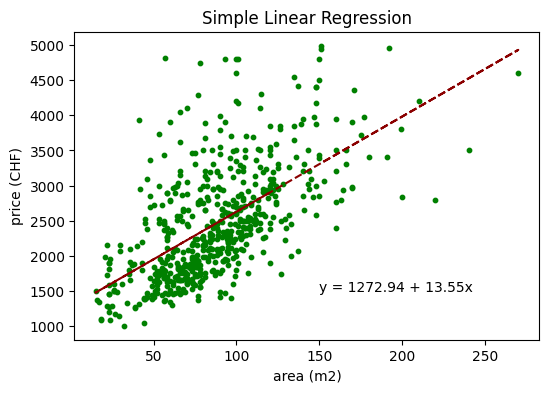

In [33]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, s=10, color='green')
plt.plot(X_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('area (m2)')
plt.ylabel('price (CHF)')

# Add regression equation
plt.text(150, 
         1500, 
         f"y = {intercept:.2f} + {slope:.2f}x", 
         color='black', 
         fontsize=10)

plt.show()

Own notes: grüne Punkte unterhalb der roten Linie sind underestimated, grüne Punkte oberhalb der roten Linie sind overestimated.

### Check model residuals (residuals = observed prices minus predicted prices)

In [34]:
# Calculate model residuals for train data
residuals = y_train - mymodel

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel[0]:.2f}')
print(f'1st Observed price in dataset: {y_train[0]:.2f}')
print(f'1st Residual price in dataset: {residuals[0]:.2f}')

1st Predicted price in dataset: 2898.72
1st Observed price in dataset: 1441.00
1st Residual price in dataset: -1457.72


### Plot histogram of residuals

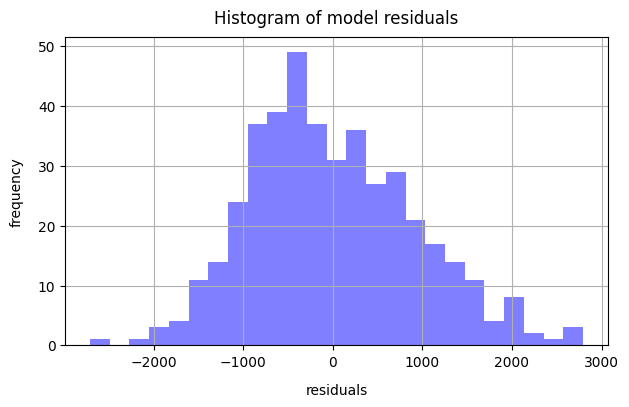

In [35]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)
plt.grid()

# Show plot
plt.show()

### Compare the observed prices with the predicted prices

In [36]:
# Create model predictions for test data
predicted = myfunc(X_test)
predicted.round(1)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed price: {y_test.iloc[i]:.1f}, Predicted price: {predicted.iloc[i]:.1f}')

Observed price: 1360.0, Predicted price: 2031.6
Observed price: 1640.0, Predicted price: 2004.5
Observed price: 1568.0, Predicted price: 2167.1
Observed price: 2290.0, Predicted price: 2207.8
Observed price: 4950.0, Predicted price: 2627.8
Observed price: 1787.0, Predicted price: 2248.4
Observed price: 3495.0, Predicted price: 2519.4
Observed price: 2450.0, Predicted price: 2031.6
Observed price: 3390.0, Predicted price: 2871.6
Observed price: 2836.0, Predicted price: 2573.6


### Task 1b) Create a new simple linear regression model with price_per_m2 as target variable and area as the explanatory variable. Check the R-squared value of this new model. State whether the R-squared value is higher compared to the original model with price as target variable and area as the explanatory variable. Also check the histogram of model residuals. State whether the residuals are normally distributed or not.

In [75]:
# Create train and test samples
X4_train, X4_test, y4_train, y4_test = train_test_split(df['area'], 
                                                    df['price_per_m2'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X4_train:')
print(X4_train.head(), '\n')

# Show y_train
print('y4_train:')
print(y4_train.head())

X4_train:
503    120
6       65
400     90
644     63
484     91
Name: area, dtype: int64 

y4_train:
503    15.83
6      28.46
400    23.22
644    33.37
484    19.78
Name: price_per_m2, dtype: float64


In [76]:
# Add constant to the model
X4_train_const = sm.add_constant(X4_train)

# Fit the model
model = sm.OLS(y4_train, X4_train_const).fit()

# Get the slope and intercept
intercept, slope = model.params

# Get the confidence intervals
conf = model.conf_int()

# Get R-squared and p-value
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the slope

# Print results of the regression model
print('Linear regression result:')
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.2f}")
print(f"Confidence Interval for Slope: {conf.iloc[1].values}")
print(f"Confidence Interval for Intercept: {conf.iloc[0].values}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")


Linear regression result:
Slope: -0.2265
Intercept: 51.24
Confidence Interval for Slope: [-0.25153761 -0.20152443]
Confidence Interval for Intercept: [48.87468211 53.60188843]
R-squared: 0.3551
P-value: 0.0000


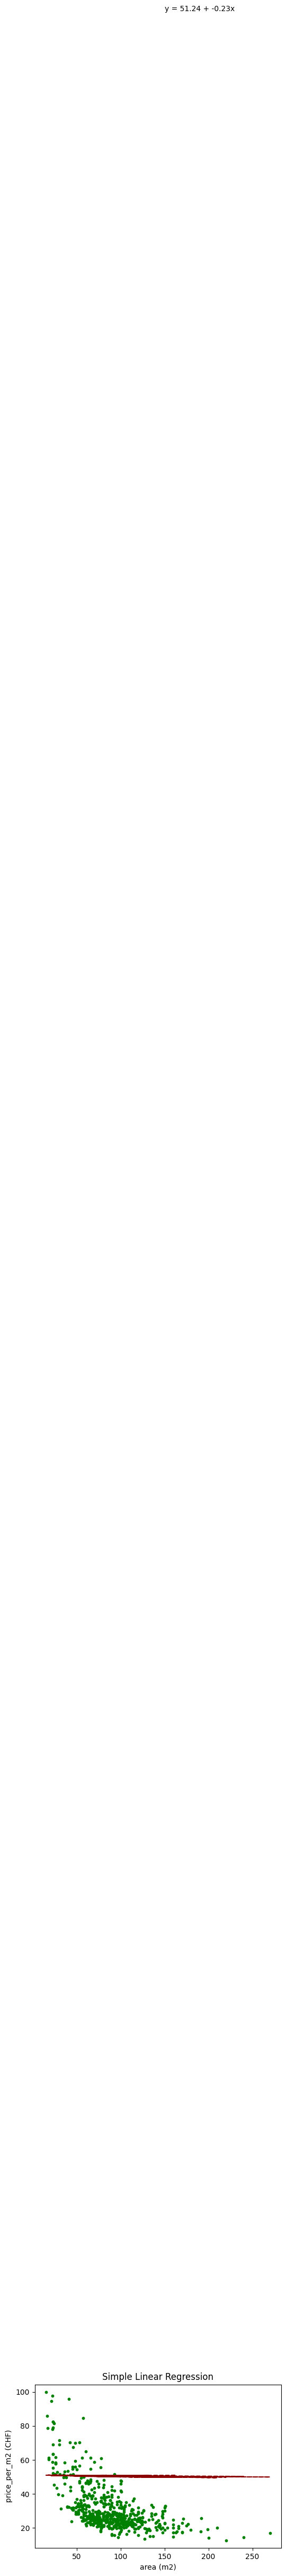

In [77]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X4_train, y4_train, s=10, color='green')
plt.plot(X4_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('area (m2)')
plt.ylabel('price_per_m2 (CHF)')

# Add regression equation
plt.text(150, 
         1500, 
         f"y = {intercept:.2f} + {slope:.2f}x", 
         color='black', 
         fontsize=10)

plt.show()

In [78]:
# Calculate model residuals for train data
residuals = y4_train - mymodel

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel[0]:.2f}')
print(f'1st Observed price in dataset: {y4_train[0]:.2f}')
print(f'1st Residual price in dataset: {residuals[0]:.2f}')

1st Predicted price in dataset: 49.77
1st Observed price in dataset: 29.41
1st Residual price in dataset: -20.36


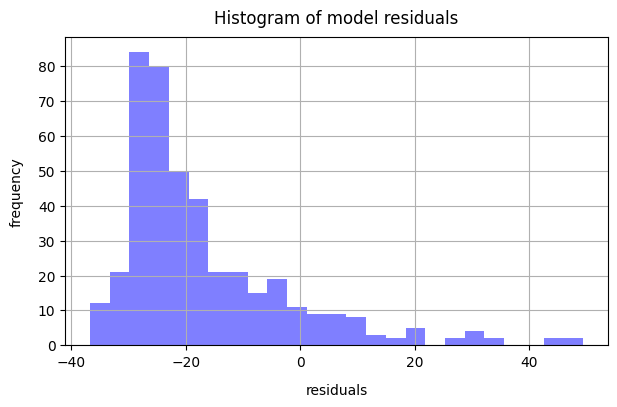

In [79]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)
plt.grid()

# Show plot
plt.show()

In [80]:
# Create model predictions for test data
predicted = myfunc(X4_test)
predicted.round(1)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed price: {y4_test.iloc[i]:.1f}, Predicted price: {predicted.iloc[i]:.1f}')

Observed price: 24.3, Predicted price: 38.6
Observed price: 30.4, Predicted price: 39.0
Observed price: 23.8, Predicted price: 36.3
Observed price: 33.2, Predicted price: 35.6
Observed price: 49.5, Predicted price: 28.6
Observed price: 24.8, Predicted price: 34.9
Observed price: 38.0, Predicted price: 30.4
Observed price: 43.8, Predicted price: 38.6
Observed price: 28.7, Predicted price: 24.5
Observed price: 29.5, Predicted price: 29.5


### Comparison:

R-squared from area & price: 0.3678

R-squared from area & price per m2: 0.3551

--> the R-squared is a little bit smaller than in the original model.

--> both plot histograms are not normally distributed, but right-skewed.

### Task 1c) Create a new simple linear regression model with price_per_m2 as target variable and rooms as the explanatory variable. Check the R-squared value. State whether the R-squared value is higher compared to the original model with price as target variable and area as the explanatory variable? Also check the histogram of model residuals. State whether the residuals are normally distributed or not.

In [81]:
# Create train and test samples
X5_train, X5_test, y5_train, y5_test = train_test_split(df['rooms'], 
                                                    df['price_per_m2'], 
                                                    test_size=0.20, 
                                                    random_state=42)
# Show X_train
print('X5_train:')
print(X5_train.head(), '\n')

# Show y_train
print('y5_train:')
print(y5_train.head())

X5_train:
503    6.5
6      3.5
400    3.5
644    2.5
484    3.5
Name: rooms, dtype: float64 

y5_train:
503    15.83
6      28.46
400    23.22
644    33.37
484    19.78
Name: price_per_m2, dtype: float64


In [82]:
# Add constant to the model
X5_train_const = sm.add_constant(X5_train)

# Fit the model
model = sm.OLS(y5_train, X5_train_const).fit()

# Get the slope and intercept
intercept, slope = model.params

# Get the confidence intervals
conf = model.conf_int()

# Get R-squared and p-value
r_squared = model.rsquared
p_value = model.pvalues[1]  # p-value for the slope

# Print results of the regression model
print('Linear regression result:')
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.2f}")
print(f"Confidence Interval for Slope: {conf.iloc[1].values}")
print(f"Confidence Interval for Intercept: {conf.iloc[0].values}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")

Linear regression result:
Slope: -6.2817
Intercept: 52.96
Confidence Interval for Slope: [-7.04647777 -5.51687599]
Confidence Interval for Intercept: [50.17743977 55.73807796]
R-squared: 0.3116
P-value: 0.0000


Text(150, 1500, 'y = 52.96 + -6.28x')

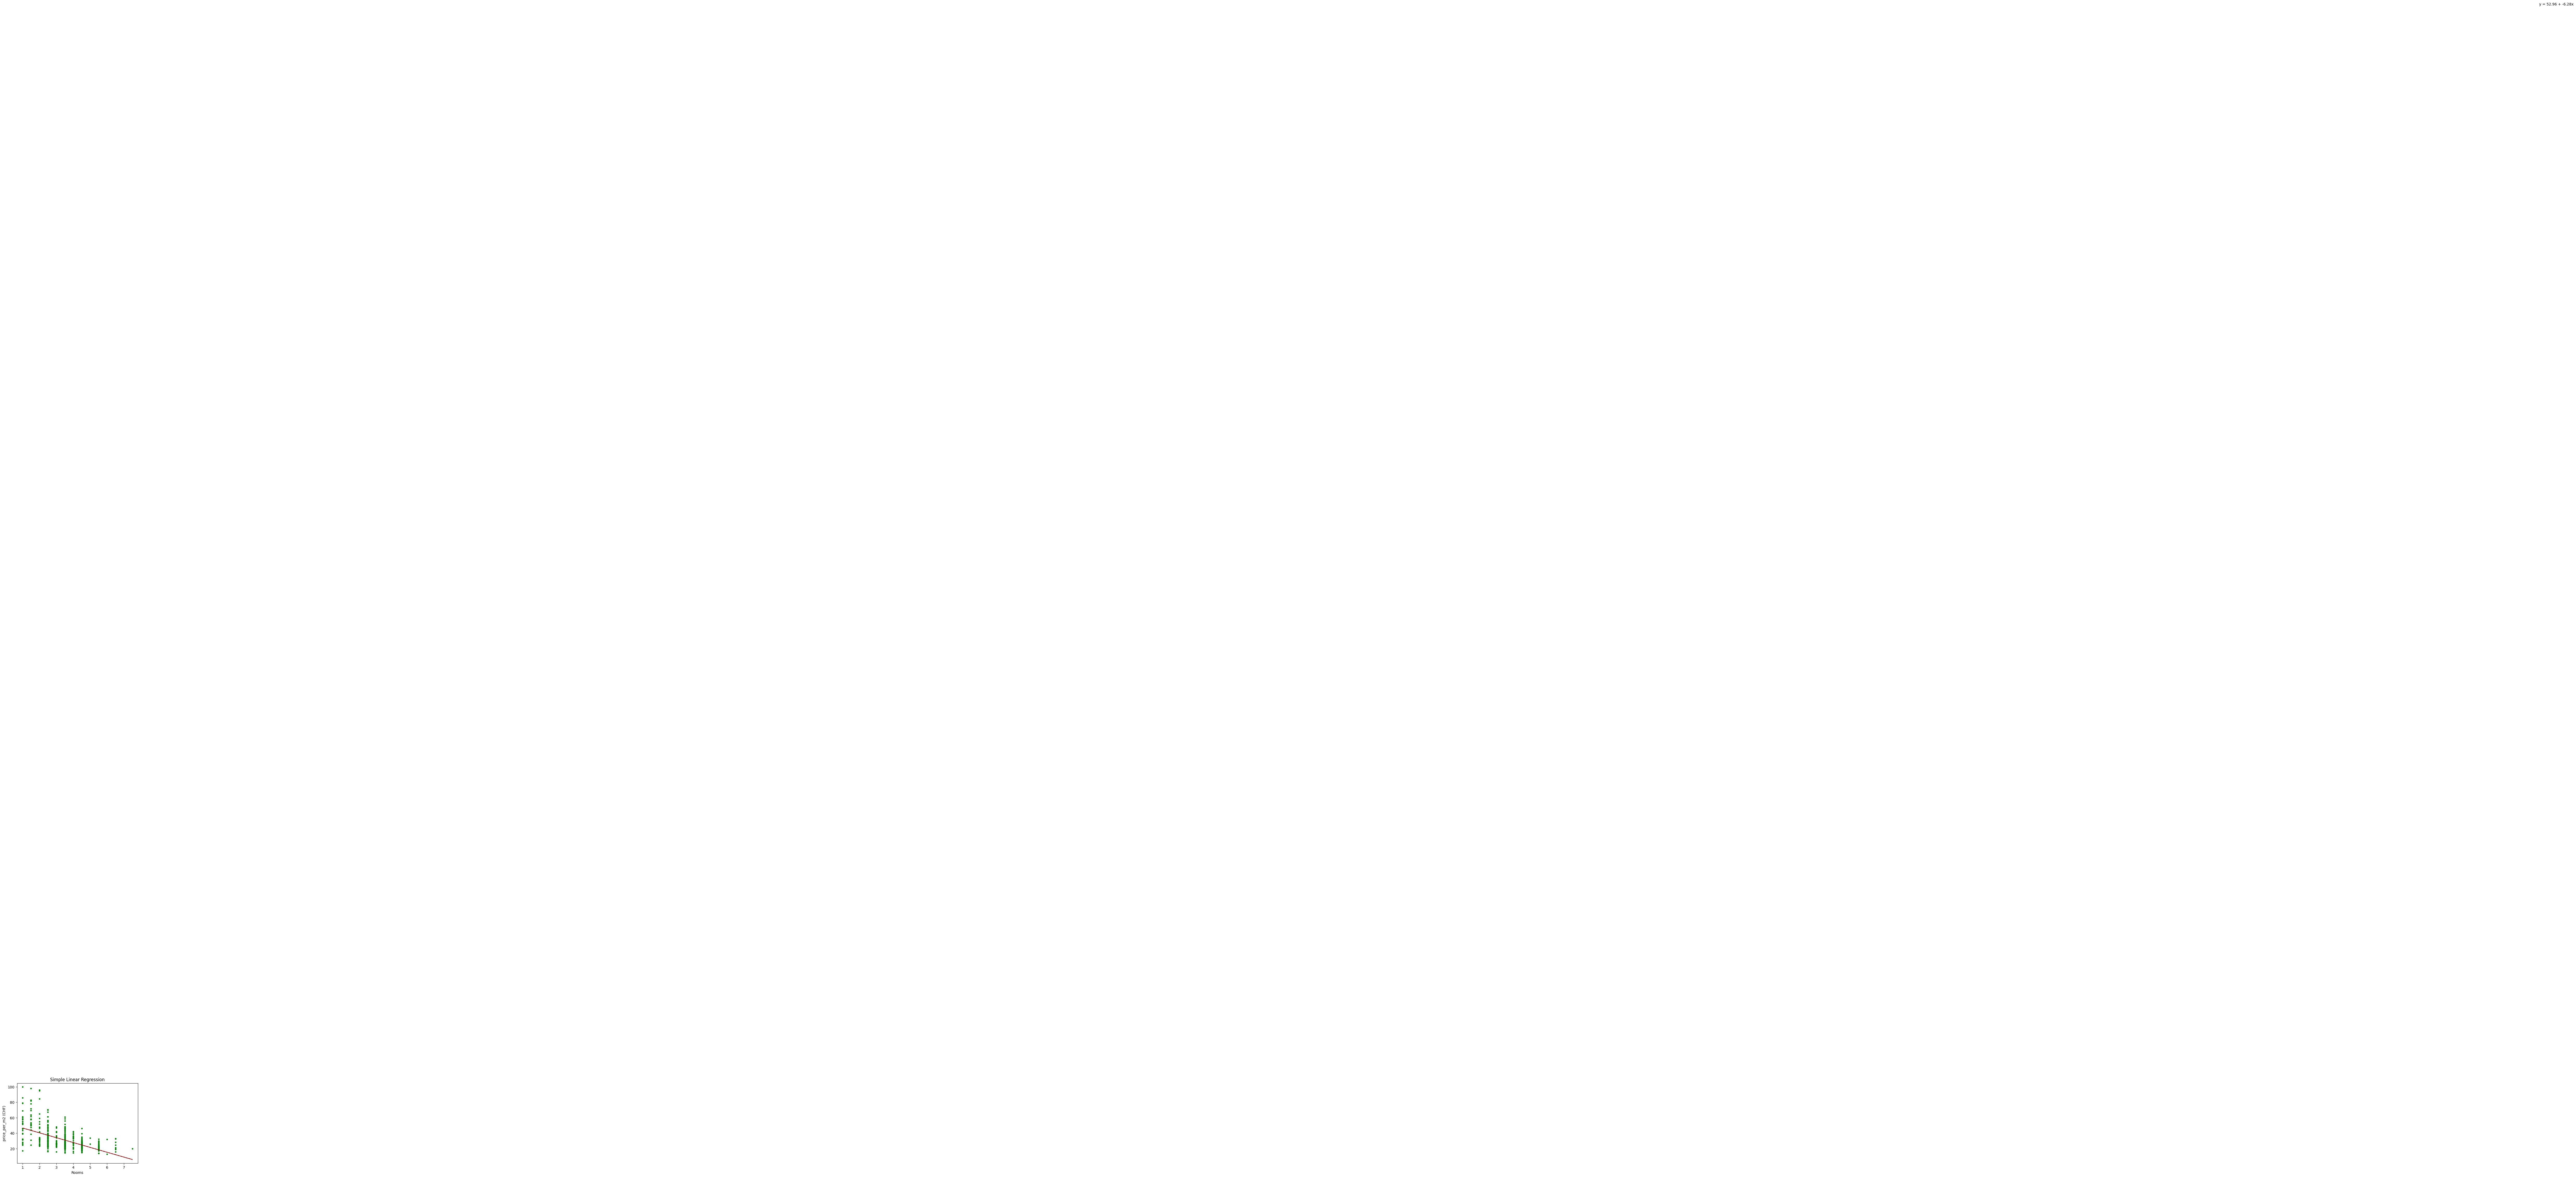

In [83]:
# Function to calculate model predictions
def myfunc(x):
    return slope * x + intercept

# Apply myfunc() to x, i.e. make predictions 
mymodel = pd.Series(map(myfunc, X5_train))

# Scatterplot with regression line
plt.figure(figsize=(6,4))
plt.scatter(X5_train, y5_train, s=10, color='green')
plt.plot(X5_train, mymodel, color='darkred', linestyle='dashed')
plt.title('Simple Linear Regression')
plt.xlabel('Rooms')
plt.ylabel('price_per_m2 (CHF)')

# Add regression equation
plt.text(150, 
         1500, 
         f"y = {intercept:.2f} + {slope:.2f}x", 
         color='black', 
         fontsize=10)

In [63]:
# Calculate model residuals for train data
residuals = y5_train - mymodel

# Check the first residual value in our data set
print(f'1st Predicted price in dataset: {mymodel[0]:.2f}')
print(f'1st Observed price in dataset: {y5_train[0]:.2f}')
print(f'1st Residual price in dataset: {residuals[0]:.2f}')

1st Predicted price in dataset: 12.13
1st Observed price in dataset: 29.41
1st Residual price in dataset: 17.28


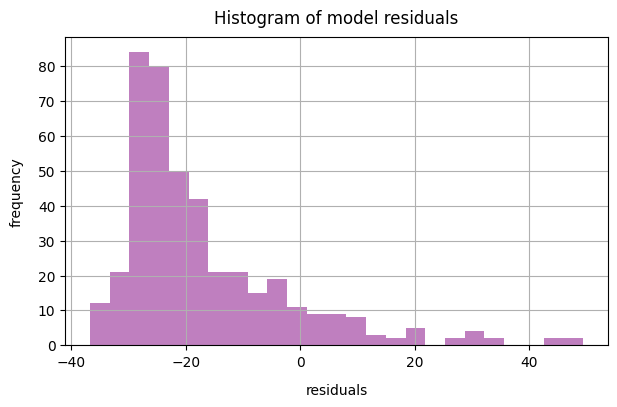

In [84]:
# Plot histogram of residuals
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=residuals, 
                            bins=25, 
                            color='purple',
                            alpha=0.5
                   )

# Set title and labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)
plt.grid()

# Show plot
plt.show()

### Comparison:

R-squared from area & price: 0.3678

R-squared from rooms & price per m2: 0.3116

--> the R-squared is a little bit smaller than in the original model.

--> both plot histograms are not normally distributed, but right-skewed.

## Multiple linear regression (more than one explanatory variable in the model)
For details see: https://www.statsmodels.org/dev/examples/notebooks/generated/predict.html

### Create train and test samples (train = 80%, test = 20% of the data)

In [46]:
# Create train and test samples (we name it X2_ and y_2 because we already used X_ and y_ above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[['area',
                                                            'pop_dens']], 
                                                        df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
     area     pop_dens
503   120   165.018625
6      65   525.662252
400    90   424.146342
644    63  1044.628957
484    91   399.525129 

y2_train:
503    1900
6      1850
400    2090
644    2102
484    1800
Name: price, dtype: int64


price = target value

area & pop_dens = explanatory variables

### Fit the multiple regression model (yes, the output is rich :-), but we need only part of it for interpretation!)

In [47]:
# Add constant to the model
X2_train_const = sm.add_constant(X2_train)

# Create the multiple regression model
olsmod = sm.OLS(y_train, X2_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     337.2
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.40e-97
Time:                        10:39:20   Log-Likelihood:                -2101.3
No. Observations:                 577   AIC:                             4209.
Df Residuals:                     574   BIC:                             4222.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.5353      1.403     26.035      0.0

### Interpretation of the relevant (in this course) statistics in the table above

<b>R-squared:</b> This is the coefficient of determination (see slides of lessons). A value of 0.522 means, that the explanatory variables explain 52% of the variaton of our target variable (rental prices) - not bad, but could be improved.

<b>coef:</b> These are the estimated coefficients of the explanatory variables ('slopes of the regression line' of each variable). These are nedded for the price predictions in our model.

<b>P>|t|:</b> These are the p-values. If < 0.05, the explanatory variables shows a statistically siginificant (5% significance level) contribution in explaining the target variable. Except for the distiance to the nearest supermarkt, all variables are significant here.

### Plot histogram of residuals

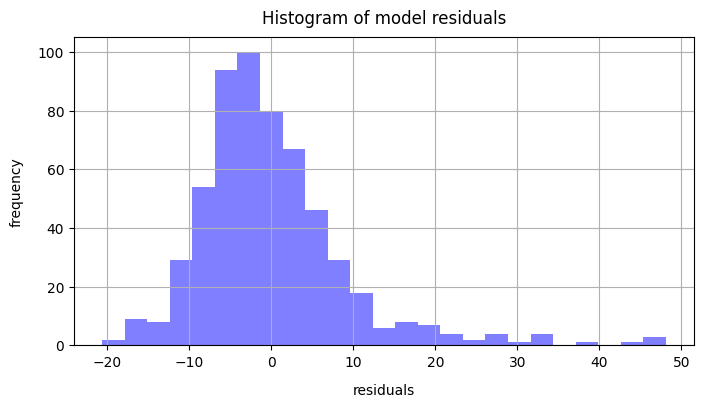

In [48]:
# Plot histogram of residuals
fig = plt.figure( figsize=(8,4))
n, bins, patches = plt.hist(x=olsres.resid, 
                            bins=25, 
                            color='blue',
                            alpha=0.5
                   )

# Set labels
plt.xlabel('residuals', fontsize=10, labelpad=10)
plt.ylabel('frequency', fontsize=10, labelpad=10)
plt.title('Histogram of model residuals', fontsize=12, pad=10)
plt.grid()
plt.show()

### Compare the observed prices with the predicted prices

In [49]:
# Add constant to X2_test
X2_test_const = sm.add_constant(X2_test)
predicted_new = olsres.predict(X2_test_const)

# Compare the observed prices with the predicted prices
for i in range(0,10):
    print(f'Observed price: {y_test.iloc[i]:.1f}, Predicted price: {predicted_new.iloc[i]:.1f}')

Observed price: 24.3, Predicted price: 33.8
Observed price: 30.4, Predicted price: 32.7
Observed price: 23.8, Predicted price: 30.7
Observed price: 33.2, Predicted price: 43.4
Observed price: 49.5, Predicted price: 26.9
Observed price: 24.8, Predicted price: 34.2
Observed price: 38.0, Predicted price: 39.7
Observed price: 43.8, Predicted price: 45.4
Observed price: 28.7, Predicted price: 21.6
Observed price: 29.5, Predicted price: 26.9


### Task 1d) Go to the section ‘Multiple linear regression …’. Include the variables tax_income and dist_supermarket as additional variables in the model. State whether the variables are statistically significant (at the 5% significance level). Note that this 2 can be figured out by looking at the part of the output-table shown below. If the value P>|t|is smaller than 0.05, than a variable is statistically significant (at the 5% significance level).

In [74]:
# Create train and test samples (we name it X3_ and y3_ because we already used X_ and y_ above)
X3_train, X3_test, y3_train, y3_test = train_test_split(df[['area',
                                                            'pop_dens',
                                                            'mean_taxable_income',
                                                            'dist_supermarket']], 
                                                        df['price'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X2_train
print('X3_train:')
print(X3_train.head(), '\n')

# Show y2_train
print('y3_train:')
print(y3_train.head())

X3_train:
     area     pop_dens  mean_taxable_income  dist_supermarket
503   120   165.018625          65380.98802       1958.318650
6      65   525.662252         111422.35870        282.095910
400    90   424.146342          72133.75058       2606.231069
644    63  1044.628957          70964.08794        564.607066
484    91   399.525129          62000.54187        646.823905 

y3_train:
503    1900
6      1850
400    2090
644    2102
484    1800
Name: price, dtype: int64


In [85]:
# Add constant to the model
X3_train_const = sm.add_constant(X3_train)

# Create the multiple regression model
olsmod = sm.OLS(y3_train, X3_train_const)
olsres = olsmod.fit()

# Print full model output
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     225.0
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          6.98e-116
Time:                        11:10:42   Log-Likelihood:                -4403.2
No. Observations:                 577   AIC:                             8816.
Df Residuals:                     572   BIC:                             8838.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -386.2135    

### Explanation: 
all variables exept of dist_supermarket are smaller than 0.05 = are statistically significant (at the 5% significance level). Only dist_supermarket is not statistically significant.

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [50]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-12-13 10:39:20
Python Version: 3.11.10
-----------------------------------
